In [14]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Load Data

In [3]:
dir = '/kaggle/input/utkface-new/UTKFace'

In [40]:
image_paths = []
age_labels = []
gender_labels = []

# Image File name: <age>_<gender>_<race>_<date>

for filename in os.listdir(dir):
    image_path = os.path.join(dir, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [41]:
image_paths = np.array(image_paths)
age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)

In [42]:
df = pd.DataFrame({'img':image_paths, 'age':age_labels,'gender':gender})
df.head()

,img,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,0
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,0
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,0


In [43]:
df.shape

(23708, 3)

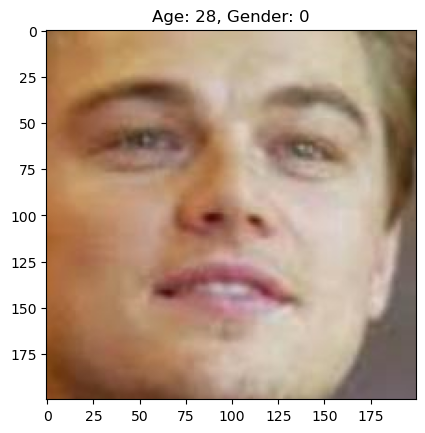

In [44]:
image = df['img'][3]
image = mpimg.imread(image)
age = df['age'][3]
gender = df['gender'][3]
plt.title(f'Age: {age}, Gender: {gender}')
plt.imshow(image)
plt.show()

## Prepare Data

In [45]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [46]:
print(train_df.shape)
print(test_df.shape)

(20000, 3)
(3708, 3)


In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [72]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True 
)

test_data_generator = ImageDataGenerator(rescale=1./255)

In [74]:
train_generator = train_data_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=dir,
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='multi_output'
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=dir,
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='multi_output'
)

Found 20000 validated image filenames.
Found 3708 validated image filenames.


## Build and Train the Model

In [75]:
from keras.applications import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten

In [76]:
vgg16 = VGG16(weights="imagenet",include_top=False, input_shape=(220, 220, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 220, 220, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 220, 220, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 220, 220, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 110, 110, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 110, 110, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 110, 110, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 55, 55, 128)       0     

In [77]:
def build_model():
    input_shape = (200, 200, 3)
    
    base_model = VGG16(weights="imagenet",include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    # freeze the first four conv blocks
    for layer in base_model.layers[15:]:
        layer.trainable = True
    
    x = base_model.layers[-1].output
    x = Flatten()(x)
    
    x1 = Dense(256, activation='relu')(x)
    x1 = Dense(256, activation='relu')(x1)
    
    x2 = Dense(256, activation='relu')(x)
    x2 = Dense(256, activation='relu')(x2)
    
    age_output = Dense(1, activation='linear', name='age')(x1)
    gender_output = Dense(1, activation='sigmoid', name='gender')(x2)
    
    model = Model(inputs=base_model.input, outputs=[age_output, gender_output])
    return model

In [78]:
model = build_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [79]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate= ReduceLROnPlateau(monitor='val_loss', mode = 'auto',patience= 3 , verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5,  restore_best_weights=True)
model_checkpoint = ModelCheckpoint('overall_best_model' , save_weights_only=True, save_best_only=True, verbose=1)

callbacks = [learning_rate, early_stopping, model_checkpoint]

In [80]:
model.compile(optimizer='adam', 
              loss={'age': 'mae', 'gender': 'binary_crossentropy'}, 
              metrics={'age': 'mae', 'gender': 'accuracy'})

In [81]:
hist = model.fit(train_generator, batch_size=32, epochs=15, validation_data=test_generator, callbacks=callbacks)

Epoch 1/15
625/625 [==============================] - ETA: 0s - loss: 10.8115 - age_loss: 10.8104 - gender_loss: 0.0011 - age_mae: 10.8104 - gender_accuracy: 0.9994
Epoch 1: val_loss improved from inf to 8.22466, saving model to overall_best_model
625/625 [==============================] - 266s 420ms/step - loss: 10.8115 - age_loss: 10.8104 - gender_loss: 0.0011 - age_mae: 10.8104 - gender_accuracy: 0.9994 - val_loss: 8.2247 - val_age_loss: 8.2247 - val_gender_loss: 5.0865e-21 - val_age_mae: 8.2247 - val_gender_accuracy: 1.0000 - lr: 0.0010
Epoch 2/15
625/625 [==============================] - ETA: 0s - loss: 8.2755 - age_loss: 8.2755 - gender_loss: 3.1003e-16 - age_mae: 8.2755 - gender_accuracy: 1.0000
Epoch 2: val_loss did not improve from 8.22466
625/625 [==============================] - 208s 333ms/step - loss: 8.2755 - age_loss: 8.2755 - gender_loss: 3.1003e-16 - age_mae: 8.2755 - gender_accuracy: 1.0000 - val_loss: 8.8333 - val_age_loss: 8.8333 - val_gender_loss: 2.5186e-15 - val

In [82]:
from tensorflow.keras.models import load_model

In [83]:
model.save('age_gender.h5')
model = load_model('age_gender.h5')

## Evaluate the Model

In [84]:
hist.history

{'loss': [10.811473846435547,
  8.275510787963867,
  7.802891254425049,
  7.549327373504639,
  7.171188831329346,
  7.038333415985107,
  6.960926532745361,
  6.717483043670654,
  6.663259506225586,
  6.5793986320495605,
  6.526468753814697,
  6.003547668457031,
  5.868392467498779,
  5.797201633453369,
  5.7592034339904785],
 'age_loss': [10.810367584228516,
  8.275510787963867,
  7.802891254425049,
  7.549327373504639,
  7.171188831329346,
  7.038333415985107,
  6.960926532745361,
  6.717483043670654,
  6.663259506225586,
  6.5793986320495605,
  6.526468753814697,
  6.003547668457031,
  5.868392467498779,
  5.797201633453369,
  5.7592034339904785],
 'gender_loss': [0.0011068504536524415,
  3.100320581452031e-16,
  1.9619961037775635e-13,
  8.323223187056694e-12,
  7.635272969430673e-11,
  4.534178588144755e-10,
  4.589208457694838e-10,
  3.5381861329675246e-10,
  2.290864581366847e-10,
  1.7934877194480947e-10,
  1.3916573449179737e-10,
  7.529914192172527e-11,
  6.855063044985954e-11

<Figure size 640x480 with 0 Axes>

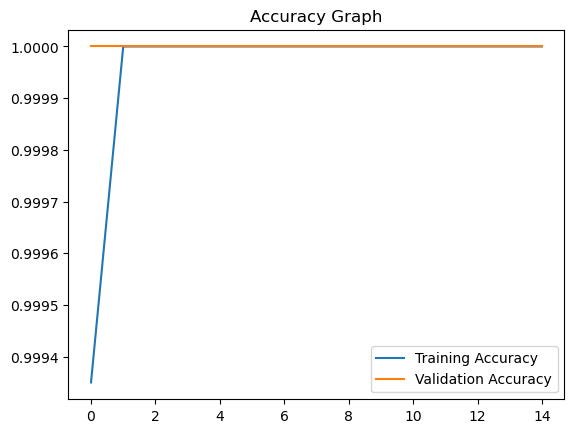

<Figure size 640x480 with 0 Axes>

In [85]:
plt.plot(hist.history['gender_accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_gender_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

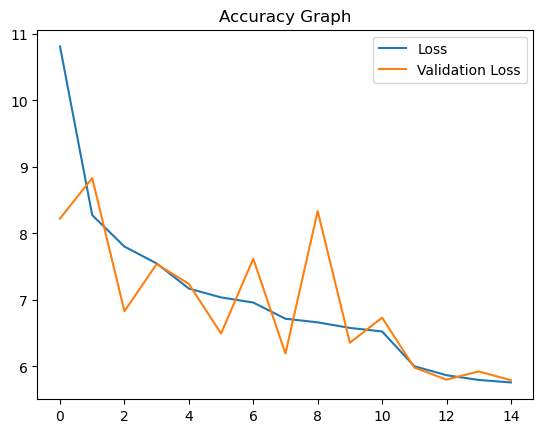

<Figure size 640x480 with 0 Axes>

In [86]:
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

In [108]:
def load_img(x):
    image = tf.io.read_file(x)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (200, 200))
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [159]:
test_sample = load_img(df['img'][3])
test_sample = tf.image.resize(test_sample, (200, 200))
test_sample = np.expand_dims(test_sample / 255, 0)

In [160]:
test_sample.shape

(1, 200, 200, 3)

In [161]:
y_hat = model.predict(test_sample)
y_hat

1/1 [==============================] - 0s 20ms/step


[array([[26.34315]], dtype=float32), array([[1.1451629e-09]], dtype=float32)]

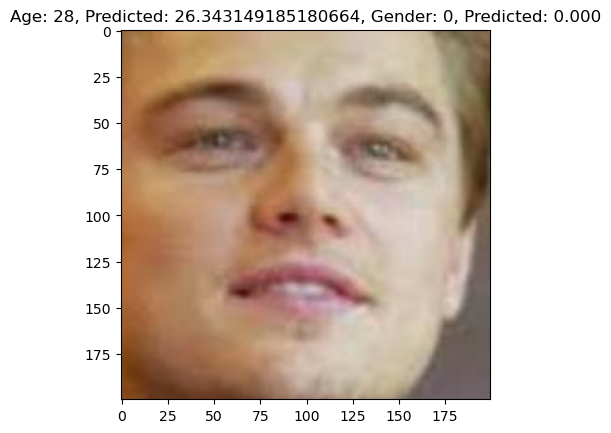

In [162]:
image = df['img'][3]
image = mpimg.imread(image)
age = df['age'][3]
pred_age = y_hat[0][0][0]
gender = df['gender'][3]
pred_gender = y_hat[1][0][0]
plt.title(f'Age: {age}, Predicted: {pred_age}, Gender: {gender}, Predicted: {pred_gender:.3f}')
plt.imshow(image)
plt.show()